# Getting more (o less) data
In an ideal world we would have the same number of observations for each variable, sampled at the same frequency, but as we saw on the last section this is not the case. Some variables may be sampled daily while other weekly, monthly or even irregularly. 

We can try  to fix this issue  by either  
- Reducing the sampling frequency by mean of **downsampling**
- *Increase the sampling frequency* by means of **interpolation**  


## Resampling
<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 1:</b> 

Read the documentation for  [`.resample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html). Select  one of the temperature timeseries (eg. one of the temperature column in `Data/Time_series_Data.txt`), plot the original data (daily observations)and the data resampled at 3 days, 5 days, a week and a month.
</p>
</div>

 ```{admonition} Tips/Help
:class: tip, dropdown

 The method `.resample()` just groups the data into bins,  a secondary operation is needed to compute the resampled values, the simplest option is to use `resample().mean()`, but we can pass other potentially useful methods such as `.max()`,`std()`, `sum()`, etc.

```

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import plotly.graph_objects as go
import iceclassic as ice

file=ice.import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/time_serie_data.txt')
Data=pd.read_csv(file,skiprows=162,index_col=0,sep='\t')   
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")



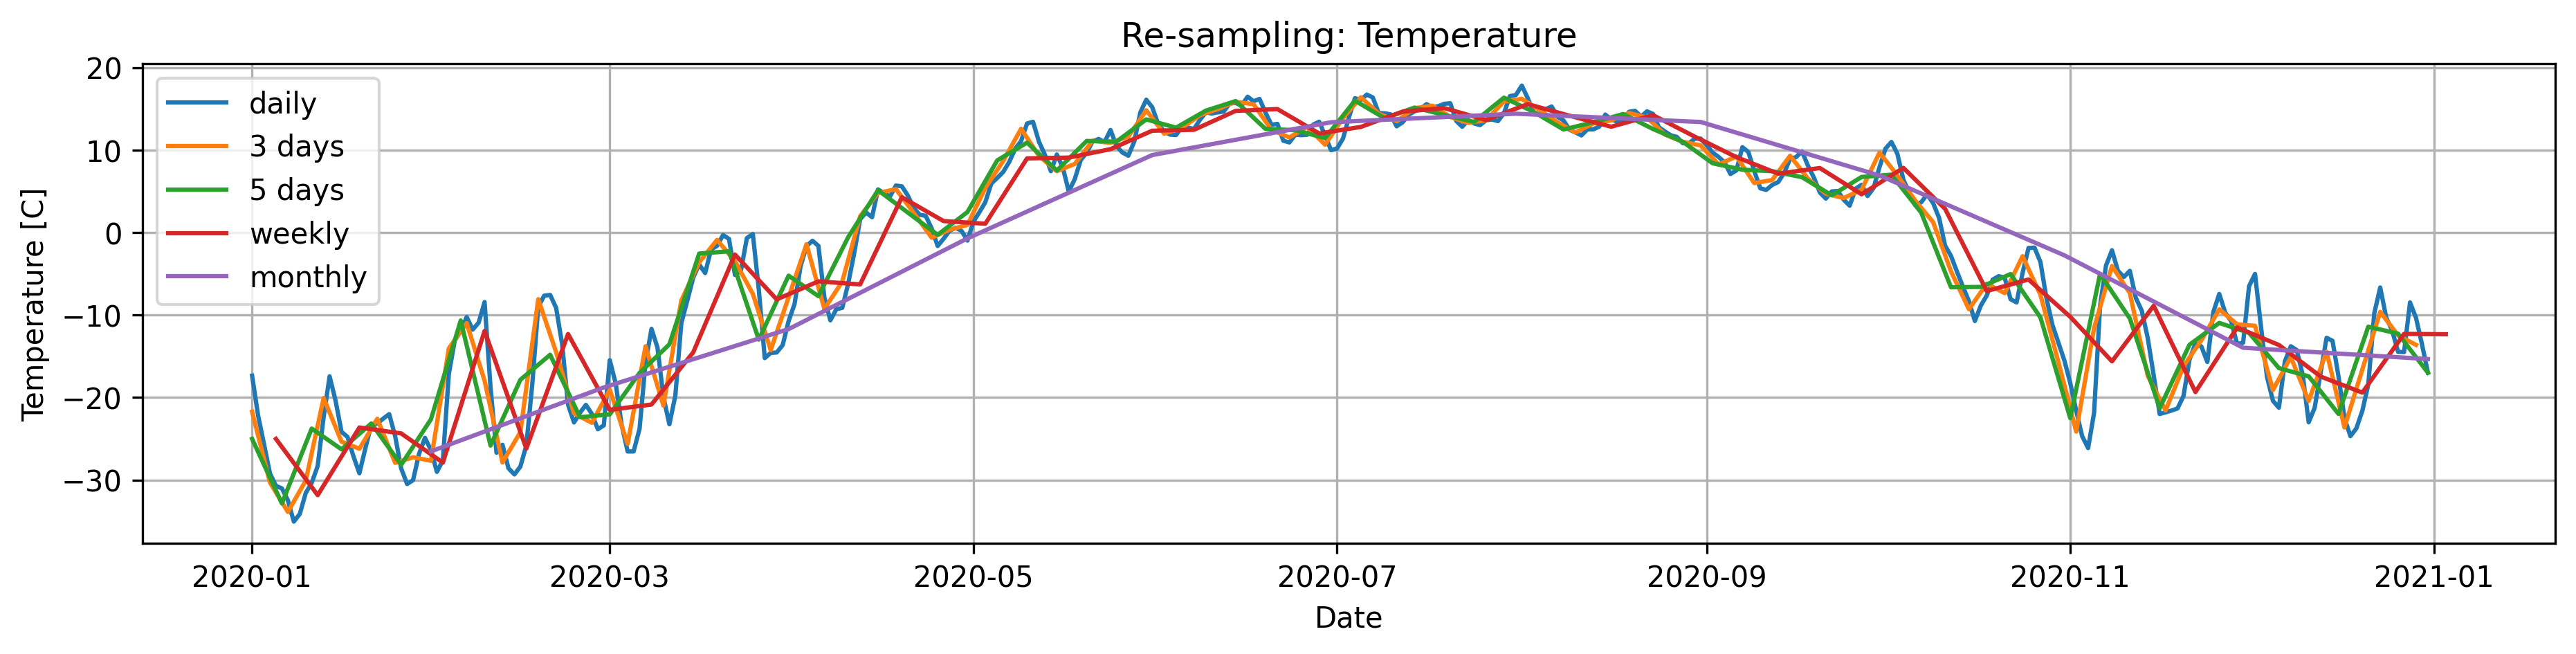

In [5]:
Temperature=Data['Regional: Air temperature [C]'] 
Temperature= Temperature[(Temperature.index.year >= 2020) & (Temperature.index.year < 2021)]
Temp_w3=Temperature.resample('3D').mean()
Temp_w5=Temperature.resample('5D').mean()
Temp_w7=Temperature.resample('W').mean()
Temp_w30=Temperature.resample('ME').mean()

fig, axs = plt.subplots(figsize=(15, 3),dpi=300)
plt.title('Re-sampling: Temperature')
plt.plot(Temperature, label='daily')
plt.plot(Temp_w3,label='3 days')
plt.plot(Temp_w5,label='5 days')
plt.plot(Temp_w7,label='weekly')
plt.plot(Temp_w30,label='monthly')
plt.ylabel("Temperature [C]")
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.show()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2:</b> 

Down-sample the rainfall observations using `.sum()`,  to every three and five days
:::
</p>
</div>

> relate this to the way we get intependent events in EVA? ( poor's man version of declustering)

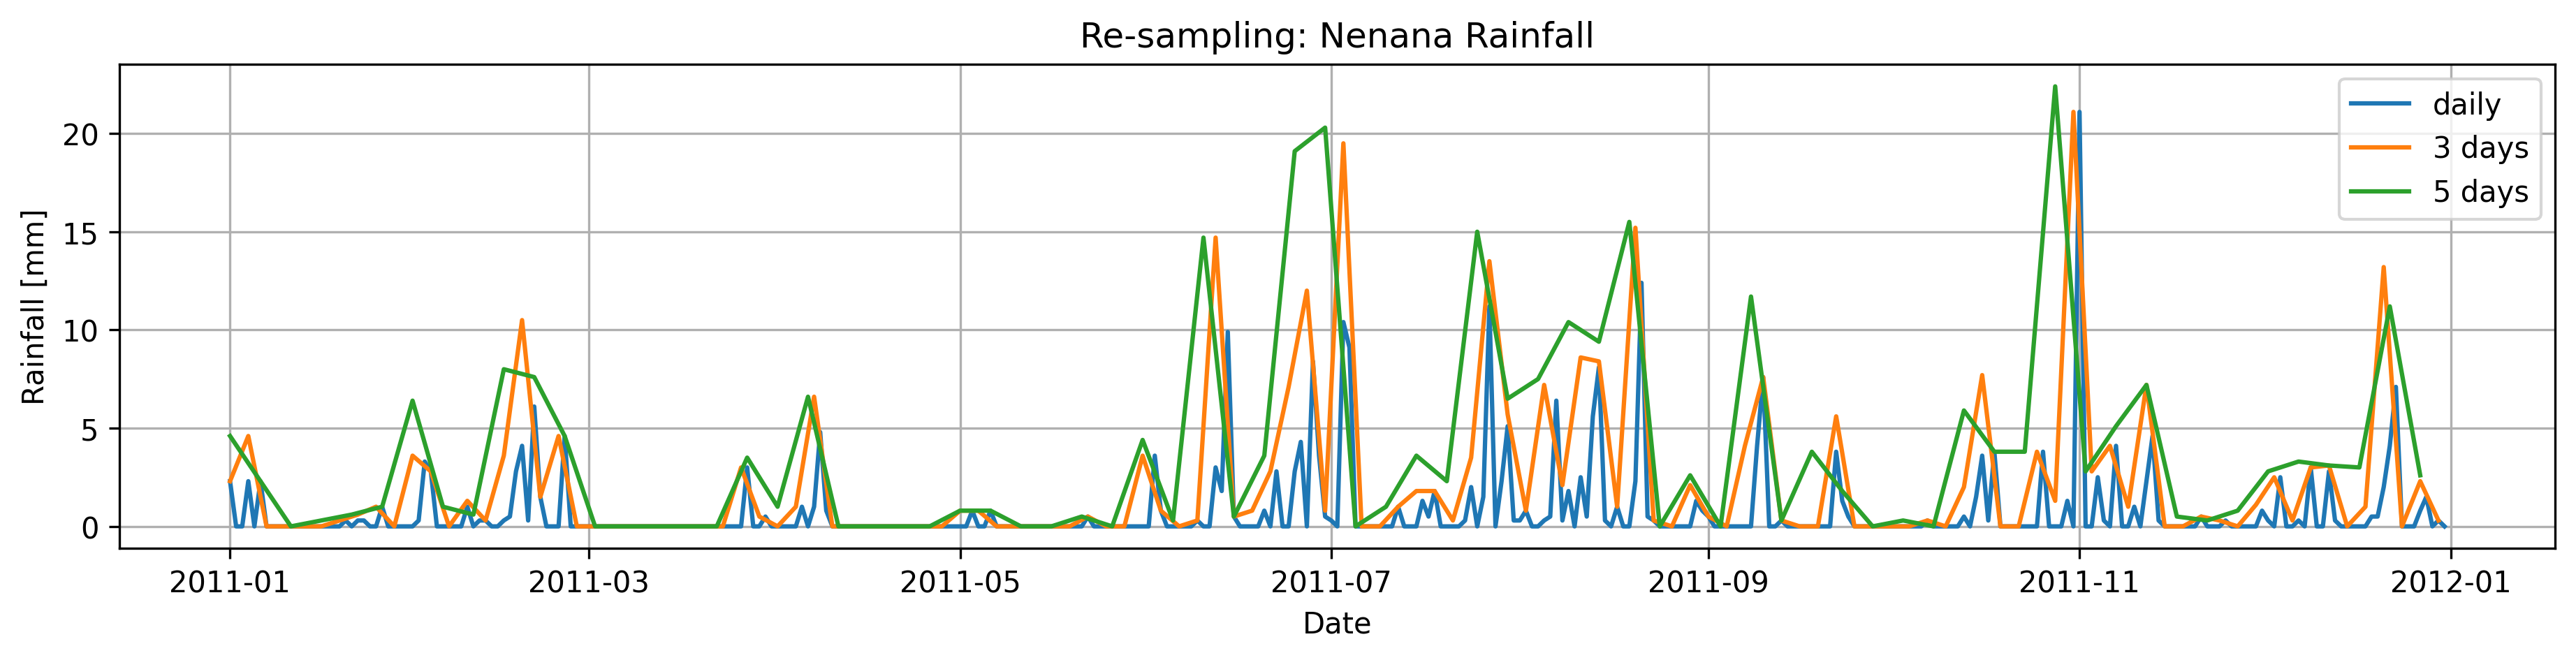

In [6]:
Rain=Data['Nenana: Rainfall [mm]']
         
Rain=Rain[(Rain.index.year >= 2011) & (Rain.index.year < 2012)]

Rain_d3=Rain.resample('3D').sum()
Rain_d5=Rain.resample('5D').sum()

fig, axs = plt.subplots(figsize=(15, 3),dpi=300)
plt.title('Re-sampling: Nenana Rainfall')
plt.plot(Rain, label='daily')
plt.plot(Rain_d3,label='3 days')
plt.plot(Rain_d5,label='5 days')
plt.ylabel("Rainfall [mm]")
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.show()

## Interpolating
Interpolation in `Pandas` can be easily accomplished using the method  [.`interpolate()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html), which internally uses [`scipy.interpolate`](https://docs.scipy.org/doc/scipy/reference/interpolate.html#module-scipy.interpolate). Unlike the pure `scipy` implementation  the number of point to be interpolated  and the location/spacing is determined by the index of the `DataFrame/Series`.


However, blindly interpolating can result in weird behaviors. For example, the following figure is the result of directly applying  `.interpolate()` to `Data['IceThickness [cm]']`.



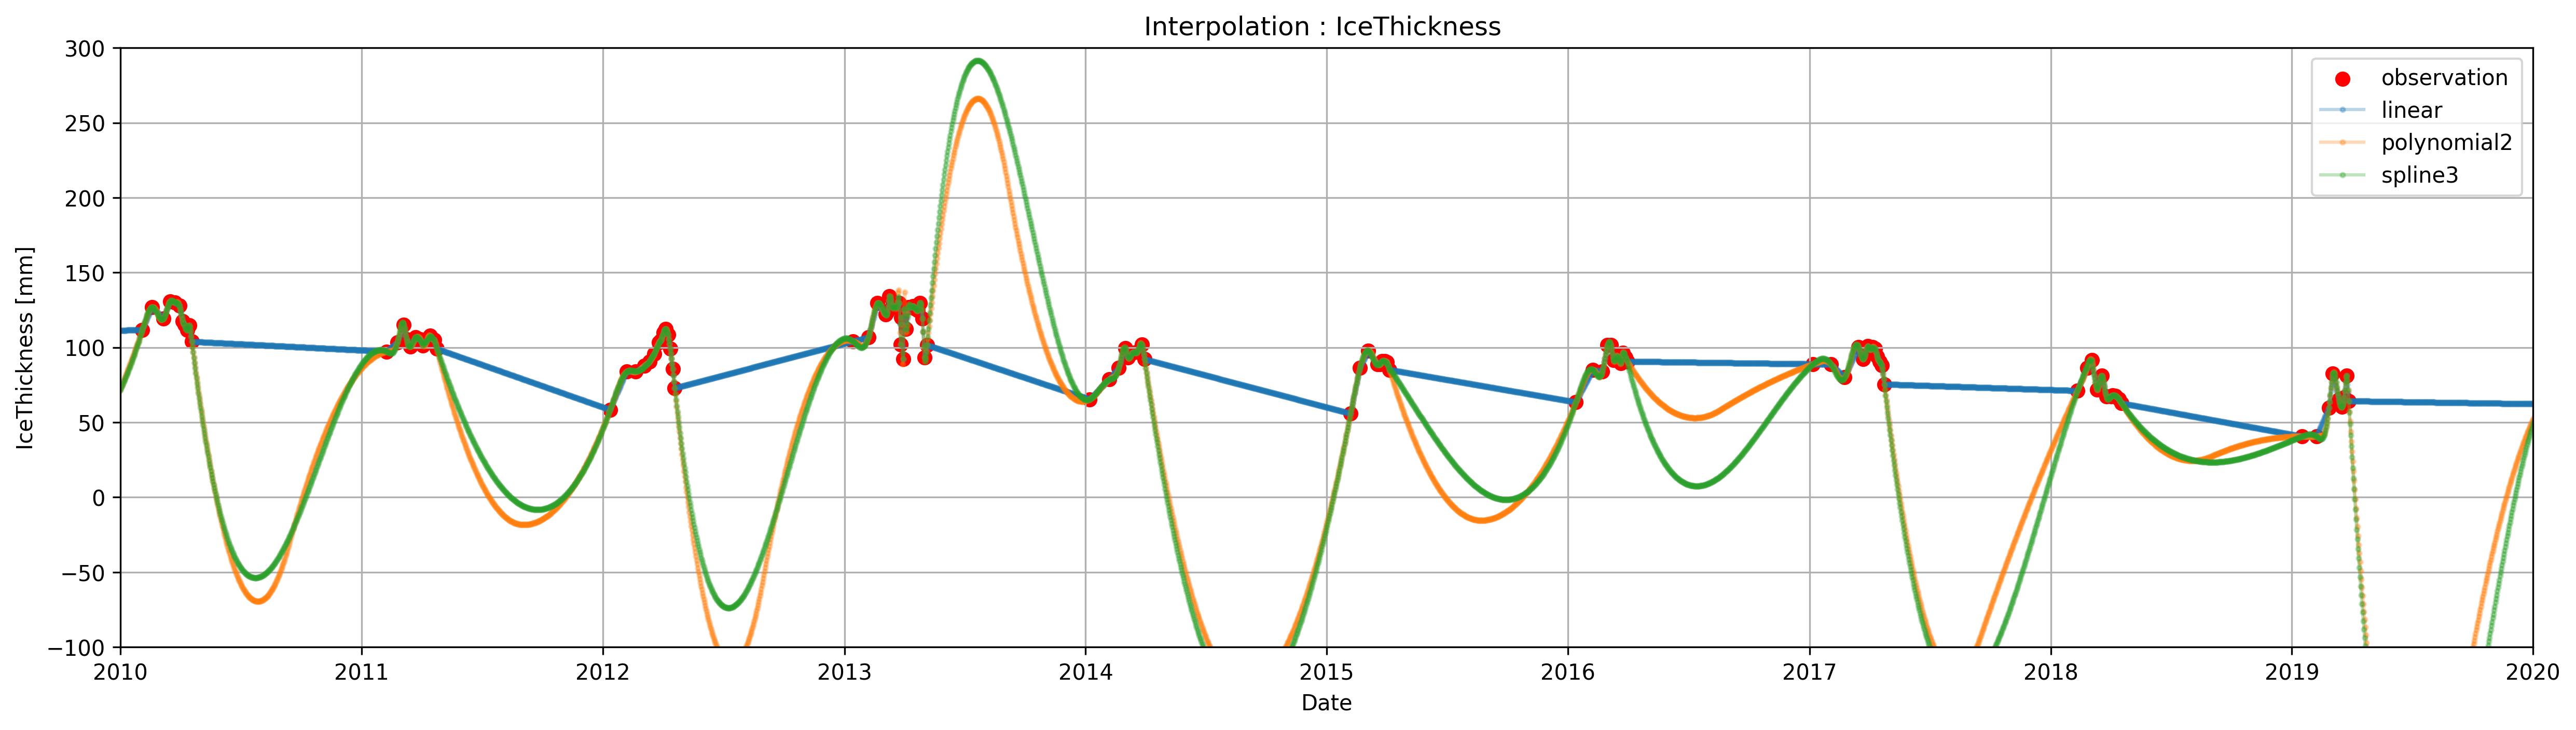

In [7]:
poly_order=2 

ICE_linear=Data['IceThickness [cm]'].interpolate(method='linear')
ICE_poly=Data['IceThickness [cm]'].interpolate(method='polynomial',order=poly_order)
ICE_spline=Data['IceThickness [cm]'].interpolate(method='spline',order=3)


plt.figure(figsize=(20, 5),dpi=300)
plt.title('Interpolation : IceThickness ')
plt.scatter(Data.index,Data['IceThickness [cm]'], label='observation',color='r')
plt.plot(ICE_linear.index,ICE_linear, label='linear ',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_poly, label=f'polynomial{poly_order}',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_spline.index,ICE_spline, label='spline3 ',marker='o',alpha=0.3,markersize=2)
plt.ylabel("IceThickness [mm]")
plt.ylim([-100,300])
plt.xlim(pd.to_datetime(['2010','2020'])) #
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.show()

You may notice that if we interpolate  `IceThickness` as-it-is,  the result has a few problems.

1. The resulting ice thickness during the summer is wrong. Because the `DataFrame` does not  have observation during the summer (as there is no ice to be measured), the interpolation uses the ice thickens measurement before the breakup, from the previous year,  and the first measure from the current year to estimate the ice thickness for the months in between.


2. The polynomial and spline interpolations result in negative values of ice thickness, which is not possible

3. Spline and polynomial interpolations have spikes in the transitions between the seasons. 



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 4:</b> 

Use indexing to assign  `IceThickness`= 0  to the observations made during the spring-summer, and use [`.clip()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html) to get rid of the negative values

</p>
</div>



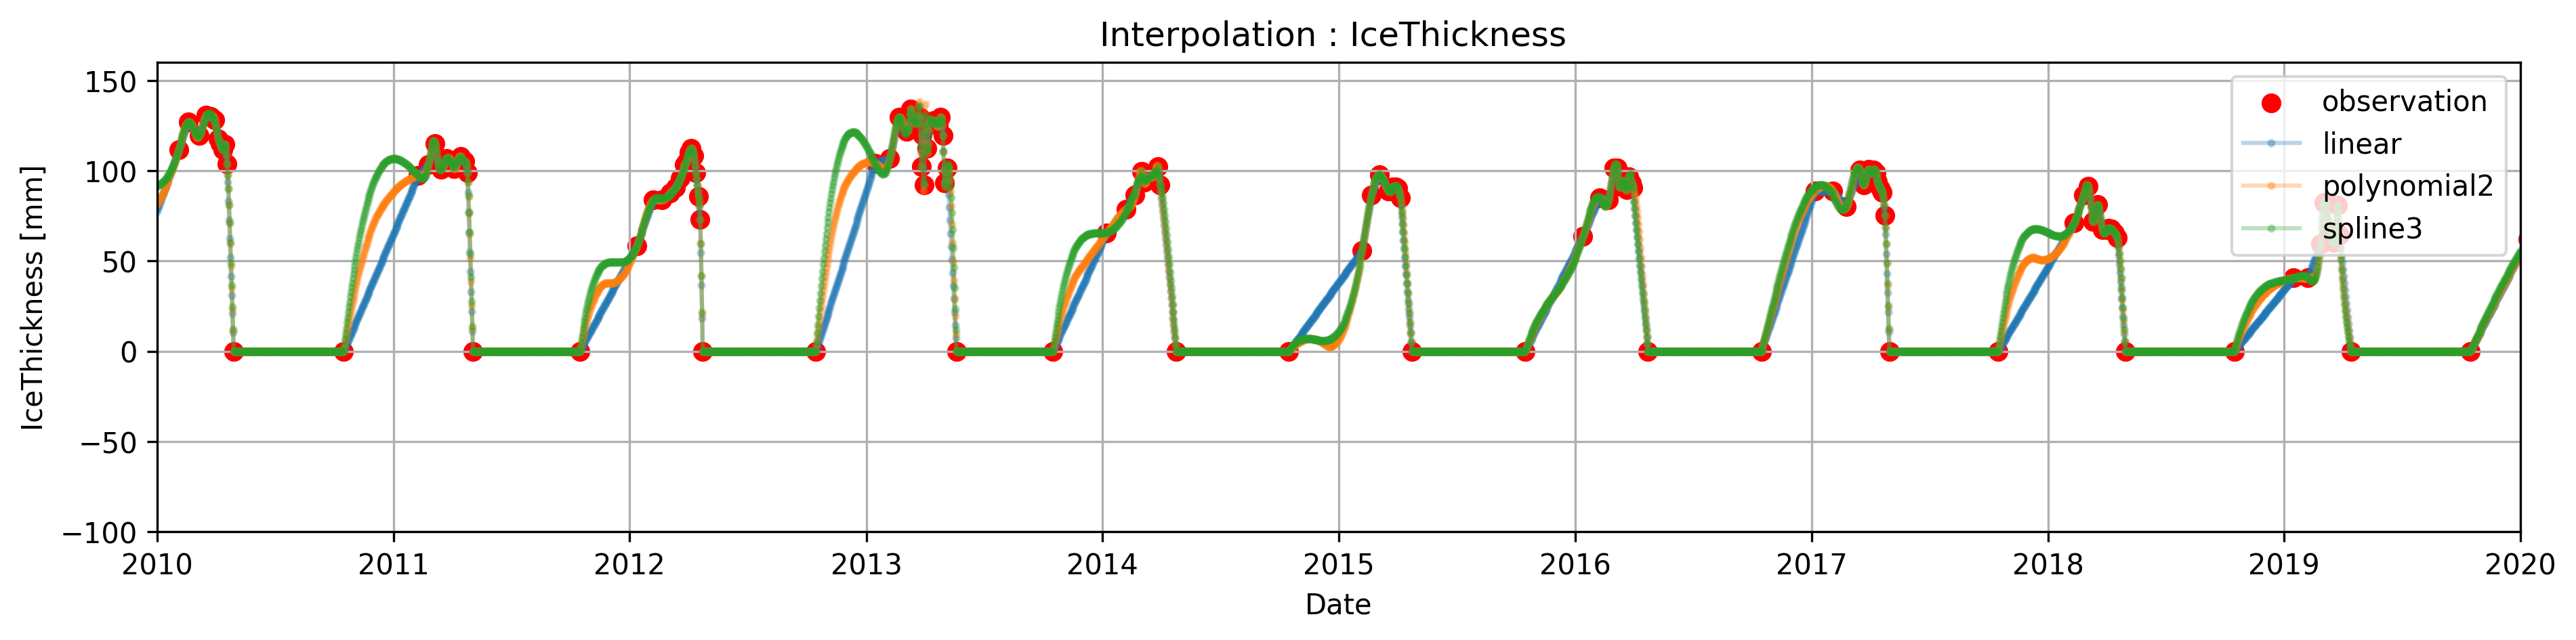

In [8]:
# fixing Problem 1

#there are multiple ways to do this a very simple and pragmatic way using only indexing is presented, using groupby()/.apply() we could get a more accurate interpolation
# similary we could have use masks using the temperature to determine the range of dates where we know that the thickness is zero  
date = pd.Timestamp('2024-10-15') 
oct_1 = date.dayofyear 
Data.loc[(Data.index.dayofyear == oct_1), 'IceThickness [cm]'] = 0
Data.loc[(Data['Days until break up'] == 0), 'IceThickness [cm]'] = 0


ICE_linear=Data['IceThickness [cm]'].interpolate(method='linear')
ICE_poly=Data['IceThickness [cm]'].interpolate(method='polynomial',order=poly_order)
ICE_spline=Data['IceThickness [cm]'].interpolate(method='spline',order=3)


#Fixig Problem 2
ICE_poly = ICE_poly.clip(lower=0)
ICE_spline = ICE_spline.clip(lower=0)


plt.figure(figsize=(15, 3),dpi=300)
plt.title('Interpolation : IceThickness ')
plt.scatter(Data.index,Data['IceThickness [cm]'], label='observation',color='r')
plt.plot(ICE_linear, label='linear',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_poly, label=f'polynomial{poly_order}',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_spline, label='spline3',marker='o',alpha=0.3,markersize=2)
plt.ylabel("IceThickness [mm]")
plt.ylim([-100,160])
plt.xlim(pd.to_datetime(['2010','2020']))
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.show()

In some circumstances, sharp transitions in the data can cause the (cubic)spline interpolation to overshoot (> explain why or for theory in class???) due to constrianf of being 2-times differentiable, or to present unusual oscillation (for example the interpolated data between oct-1 and the next observation present undesired oscillation). 

This phenomena can be fixed by using  'monotones splines', this splines relax some of the constrains and are one time differentiable ( if we mention this we kinda assume that they know how a spline is constructed)
In particular, `pandas` ( through `scipy` ) has two methods [`pchip`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.pchip_interpolate.html) and [`akima`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Akima1DInterpolator.html) 



:::{card}ex
Compare the cubic spline interpolation with the `akima` and `pchip` interpolation

:::



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 5:</b> 

Compare the cubic spline interpolation with the `akima` and `pchip` interpolation 
</p>
</div>


> mention smth about boudnary condition in splines? higher dimensions? etc.  in interp there is a lot to mention, this guide cover pretty much everything
(https://docs.scipy.org/doc/scipy/tutorial/interpolate/1D.html) 


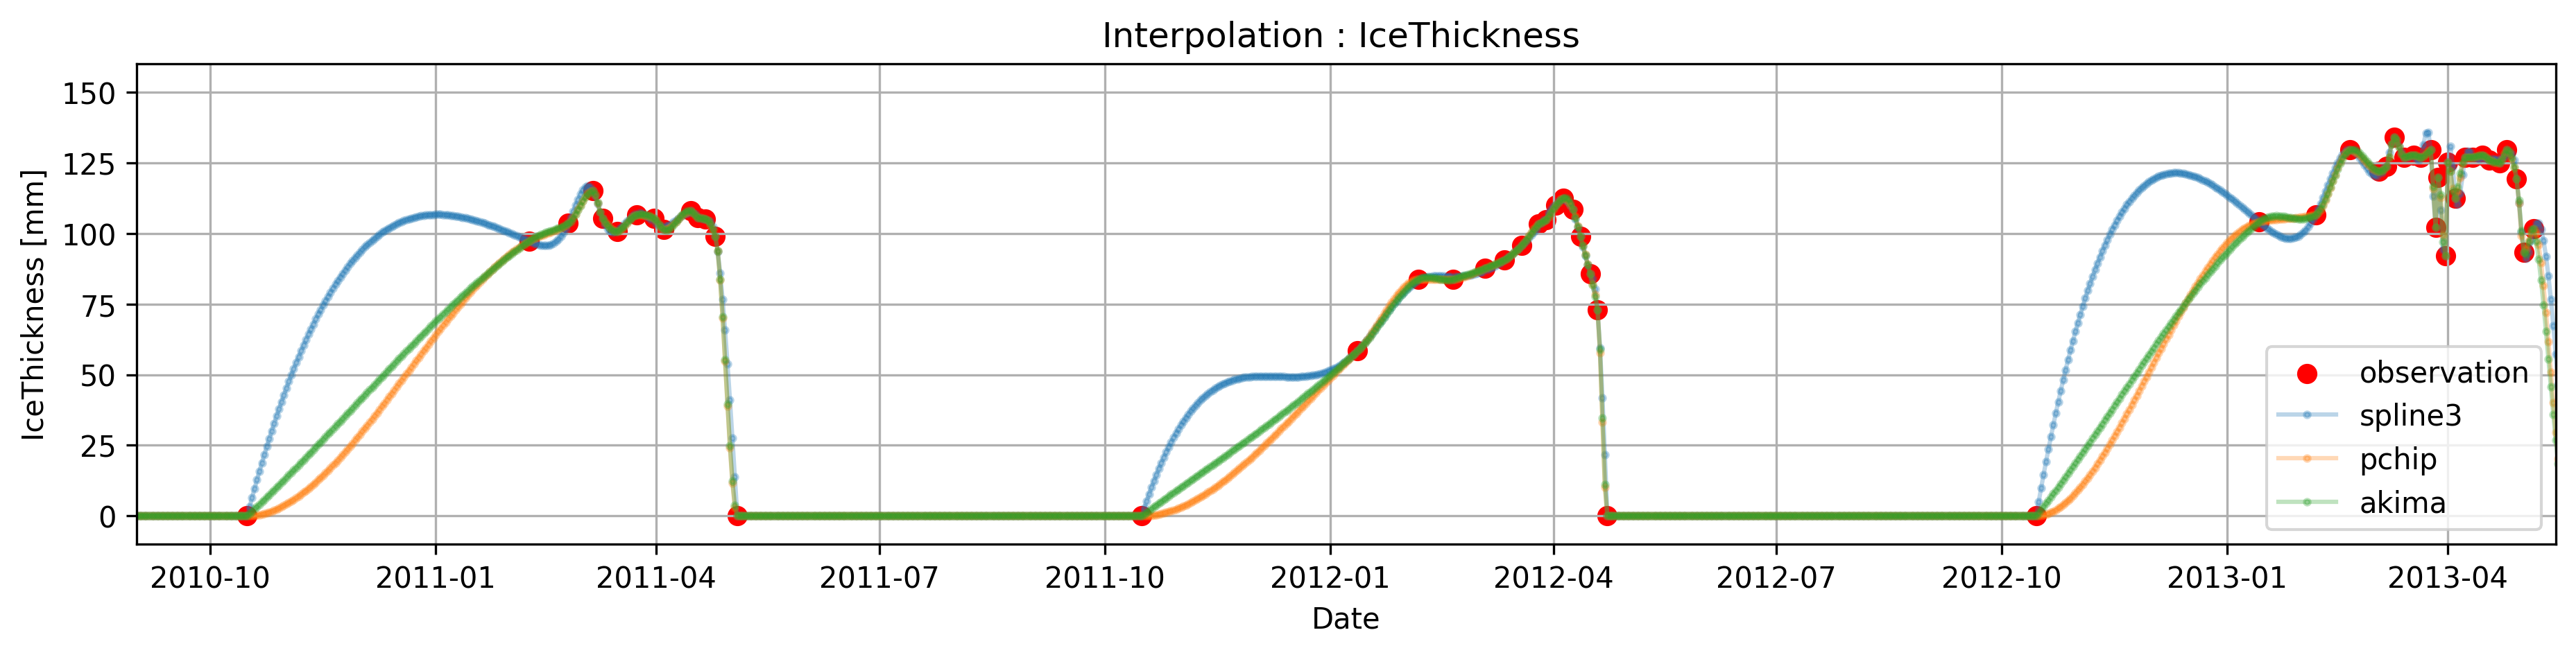

In [9]:
ICE_spline=Data['IceThickness [cm]'].interpolate(method='spline',order=3)
ICE_pchip=Data['IceThickness [cm]'].interpolate(method='pchip')
ICE_akima=Data['IceThickness [cm]'].interpolate(method='akima')

ICE_spline = ICE_spline.clip(lower=0)
ICE_pchip = ICE_pchip.clip(lower=0)
ICE_akima = ICE_akima.clip(lower=0)

plt.figure(figsize=(15, 3),dpi=300)
plt.title('Interpolation : IceThickness ')
plt.scatter(Data.index,Data['IceThickness [cm]'], label='observation',color='r')
plt.plot(ICE_spline, label='spline3',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_pchip, label='pchip',marker='o',alpha=0.3,markersize=2)
plt.plot(ICE_akima, label='akima',marker='o',alpha=0.3,markersize=2)
plt.ylabel("IceThickness [mm]")
plt.xlim(pd.to_datetime(['2010/09/01','2013/05/15']))
plt.ylim([-10,160])
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.show()

In [10]:
# if we are happy with the results, we cna either create a new column in the df, or replace the original with the interpolated values
ICE_pchip.replace(0,None,inplace=True) # we artificially added these zeros during the spring/summer, lets take them out
Data['IceThickness [cm]']=ICE_pchip